# Genrify Project - Phase II
# Music genre prediction

Henri Toussaint<br>
Victor Saint Guilhem<br>
Benoît Lafon<br>

The project sets out to predict the genre of a music using the Spotify API, which provides audio features for each tracks. To collect the tracks, we used a recommandation function with a genre seed. We handpicked 20 genres in order to best represent tracks, and from each genre, we collected 100 tracks.

In [25]:
from genrify_module import *
%matplotlib inline

# Data Loading Using Pandas

In [26]:
data = pd.read_csv("music_collection.csv")
#data = data.iloc[np.random.permutation(len(data))]
pd_attributes = data.loc[:,'acousticness':'valence']
attributes = np.array(pd_attributes)

# Data Shape

In [27]:
print('Number of instances: ' + str(data.shape[0]))
print('Number of attributes: ' + str(pd_attributes.shape[1]))
print('Attributes:')
for i in pd_attributes.columns.values:
    print('\t'+str(i))

Number of instances: 2000
Number of attributes: 13
Attributes:
	acousticness
	danceability
	duration_ms
	energy
	instrumentalness
	key
	liveness
	loudness
	mode
	speechiness
	tempo
	time_signature
	valence


# Performance Measure

For our performance measure, we chose the accuracy, as we have a multiclass classification problem. We felt that the other measures like precision, recall or ROC were more fitted to binary data and are in fact more complicated to get through cross validation (using the function cross_val_score, we can only use accuracy on multiclass data).

In [28]:
#To store the performance of different models
global_accuracy_scores = {}

### Scaling

In [29]:
sc_attributes = scale(attributes)

### Multinomial Target Variable

In [30]:
GENRES = ['alternative','blues','classical','country','electro','folk','french','hard-rock','heavy-metal','hip-hop','indie','jazz','pop','psych-rock','punk-rock','r-n-b','reggae','rock','soul','techno']
target_multinomial = []
for i in data['genre']:
    target_multinomial.append(GENRES.index(i))
target_multinomial=np.array(target_multinomial)

# Baselines

Our data does not have a clear majority class, as we chose to pick exactly 100 songs from 20 genres. So, as expected, the majority class classifier labels everything as one genre and we get an accuracy of 1/20.

### Random prediction

In [31]:
random_model = DummyClassifier(strategy='uniform')

random_acc_scores = cross_val_score(random_model, sc_attributes, target_multinomial,cv=10)
avg_random_acc = np.mean(random_acc_scores)
print("Averaged Accuracy: " + str(avg_random_acc))
global_accuracy_scores["Random"] = avg_random_acc

Averaged Accuracy: 0.055


### Predicting the majority class

In [32]:
majo_model = DummyClassifier(strategy='most_frequent')

majo_acc_scores = cross_val_score(majo_model, sc_attributes, target_multinomial,cv=10)
avg_majo_acc = np.mean(majo_acc_scores)
print("Averaged Accuracy: " + str(avg_majo_acc))
global_accuracy_scores["Majority Class "] = avg_majo_acc

Averaged Accuracy: 0.05


# Model selection

We tried a range of different classifiers with different parameters. We did not try every possible configurations, and instead focused on some that we felt were more pertinent. Through trial and error we eliminated some models and parameters that we believed did not add anything to our current presentation.

Some models, like Neural Network, take a lot of time to compute (around 5 to 10 minutes depending on your computer).

### Logistic Regression

In [33]:
Cs = [0.01, 0.1]
Cs.extend(range(10, 310, 10))
max_score = 0
lr_best_c = Cs[0]

for c in Cs:
    model = LogisticRegression(C=c, multi_class='multinomial', solver='newton-cg', random_state=1)
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10, scoring='accuracy'))
    print("Averaged accuracy for c=" + str(c) + ": " + str(score) )
    if (score > max_score):
        max_score = score
        lr_best_c = c

print("Best accuracy is "+ str(max_score) + " with c=" + str(lr_best_c))
global_accuracy_scores["Logistic Regression "] = max_score


Averaged accuracy for c=0.01: 0.335
Averaged accuracy for c=0.1: 0.359
Averaged accuracy for c=10: 0.365
Averaged accuracy for c=20: 0.3675
Averaged accuracy for c=30: 0.3685
Averaged accuracy for c=40: 0.37
Averaged accuracy for c=50: 0.37
Averaged accuracy for c=60: 0.37
Averaged accuracy for c=70: 0.37
Averaged accuracy for c=80: 0.3705
Averaged accuracy for c=90: 0.3705
Averaged accuracy for c=100: 0.3705
Averaged accuracy for c=110: 0.3705
Averaged accuracy for c=120: 0.3705
Averaged accuracy for c=130: 0.371
Averaged accuracy for c=140: 0.371
Averaged accuracy for c=150: 0.371
Averaged accuracy for c=160: 0.37
Averaged accuracy for c=170: 0.371
Averaged accuracy for c=180: 0.3705
Averaged accuracy for c=190: 0.3705
Averaged accuracy for c=200: 0.3705
Averaged accuracy for c=210: 0.3705
Averaged accuracy for c=220: 0.3705
Averaged accuracy for c=230: 0.3705
Averaged accuracy for c=240: 0.3705
Averaged accuracy for c=250: 0.3705
Averaged accuracy for c=260: 0.3705
Averaged accuracy

### Decision Tree

For the decision tree, default parameters seems to not enhance the result much. 

Therefore, we just launched it several times to find a maximum accuracy.

In [34]:
max_score = 0
for i in range(100):
    model = tree.DecisionTreeClassifier()
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
#    print("Averaged accuracy: " + str(score) )
    if (score >= max_score):
        max_score = score

print("Best accuracy is "+ str(max_score))
global_accuracy_scores["Decision Tree "] = max_score

Best accuracy is 0.247


### Naïve Bayes

In [35]:
NB_model = GaussianNB()
NB_acc_scores = cross_val_score(NB_model, sc_attributes, target_multinomial,cv=10)

avg_NB_acc = np.mean(NB_acc_scores)
print("Averaged Naïve Bayes Accuracy: " + str(avg_NB_acc))
global_accuracy_scores["Naive Bayes"] = max_score

Averaged Naïve Bayes Accuracy: 0.302


### Neural Networks

In [36]:
Alphas = [0.1, 1, 2, 5, 10, 20]
HLsizes = [20, 25, 30, 50, 100, 200]
Activation_functions = ['tanh', 'identity', 'logistic', 'relu']
default_alpha = 5
default_size = 25
final_score = 0
final_alpha = 0
final_size = 0

for f in Activation_functions:
    print("\nUsing " + f + " as activation function:")
    max_score=0
    best_alpha = default_alpha
    best_size = default_size
    
    for a in Alphas:
        model = MLPClassifier(hidden_layer_sizes=(best_size,),alpha=a,activation=f, solver='lbfgs', random_state = 1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
        print("Averaged accuracy for alpha=" + str(a) + ": " + str(score) )
        if (score >= max_score):
            max_score = score
            best_alpha = a
    
    print("Best accuracy is "+ str(max_score) + " with alpha=" + str(best_alpha))
    
    max_score = 0
    for s in HLsizes:
        model = MLPClassifier(hidden_layer_sizes=(s,), alpha=best_alpha, activation=f, solver='lbfgs', random_state = 1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
        print("Averaged accuracy for hidden layer size s=" + str(s) + ": " + str(score) )
        if (score > max_score):
            max_score = score
            best_size = s
    
    print("Best accuracy is "+ str(max_score) + " with hidden layer size s=" + str(best_size))
    if (max_score > final_score):
        final_score = max_score
        final_alpha = best_alpha
        final_size = best_size

print("\nThe best final accuracy is " + str(final_score) + " with a hidden layer size of s=" + str(final_size) + " and alpha=" + str(final_alpha)+ ".\n")
global_accuracy_scores["Neural Networks"] = final_score


Using tanh as activation function:
Averaged accuracy for alpha=0.1: 0.302
Averaged accuracy for alpha=1: 0.3255
Averaged accuracy for alpha=2: 0.3375
Averaged accuracy for alpha=5: 0.3635
Averaged accuracy for alpha=10: 0.371
Averaged accuracy for alpha=20: 0.3675
Best accuracy is 0.371 with alpha=10
Averaged accuracy for hidden layer size s=20: 0.3665
Averaged accuracy for hidden layer size s=25: 0.371
Averaged accuracy for hidden layer size s=30: 0.3675
Averaged accuracy for hidden layer size s=50: 0.37
Averaged accuracy for hidden layer size s=100: 0.3665
Averaged accuracy for hidden layer size s=200: 0.3695
Best accuracy is 0.371 with hidden layer size s=25

Using identity as activation function:
Averaged accuracy for alpha=0.1: 0.3715
Averaged accuracy for alpha=1: 0.3685
Averaged accuracy for alpha=2: 0.3665
Averaged accuracy for alpha=5: 0.3675
Averaged accuracy for alpha=10: 0.364
Averaged accuracy for alpha=20: 0.3655
Best accuracy is 0.3715 with alpha=0.1
Averaged accuracy f

### Support Vector Machine

In [37]:
Cs = [0.01,0.1,1,2,3,5]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    print("Using "+ k + " kernel")
    max_score = 0
    best_c = Cs[0]
    for c in Cs:
        model = SVC(kernel = k,C=c, random_state=1)
        score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10, scoring='accuracy'))
        print("Averaged accuracy for c=" + str(c) + ": " + str(score) )
        if (score > max_score):
            max_score = score
            best_c = c
            
    print("Best accuracy is "+ str(max_score) + " with c=" + str(best_c)+"\n")

global_accuracy_scores["Support Vector Machine"] = max_score

Using linear kernel
Averaged accuracy for c=0.01: 0.3245
Averaged accuracy for c=0.1: 0.3665
Averaged accuracy for c=1: 0.3655
Averaged accuracy for c=2: 0.3645
Averaged accuracy for c=3: 0.366
Averaged accuracy for c=5: 0.3645
Best accuracy is 0.3665 with c=0.1

Using poly kernel
Averaged accuracy for c=0.01: 0.1395
Averaged accuracy for c=0.1: 0.207
Averaged accuracy for c=1: 0.293
Averaged accuracy for c=2: 0.302
Averaged accuracy for c=3: 0.299
Averaged accuracy for c=5: 0.3025
Best accuracy is 0.3025 with c=5

Using rbf kernel
Averaged accuracy for c=0.01: 0.3125
Averaged accuracy for c=0.1: 0.3155
Averaged accuracy for c=1: 0.346
Averaged accuracy for c=2: 0.3445
Averaged accuracy for c=3: 0.3415
Averaged accuracy for c=5: 0.3315
Best accuracy is 0.346 with c=1

Using sigmoid kernel
Averaged accuracy for c=0.01: 0.277
Averaged accuracy for c=0.1: 0.287
Averaged accuracy for c=1: 0.2945
Averaged accuracy for c=2: 0.29
Averaged accuracy for c=3: 0.2855
Averaged accuracy for c=5: 0.

### Random Forest

According to [the documentation of scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html#parameters), the main parameters to adjust when using these methods are n_estimators and max_features.

Besides, it can be seen in the same page that empirical good default value for classification tasks is max_features=sqrt(n_features), which is the default value.

Thus, the optimization will only be done over n_estimators.

After a first loop, we saw that there is no significan enhancement after n_estimators > 50

In [38]:
estimators = range(50, 71, 1)
max_score = 0
best_estimator = 1

for e in estimators:
    model = RandomForestClassifier(n_estimators=e, random_state=1)
    score = np.mean(cross_val_score(model, sc_attributes, target_multinomial,cv=10))
    print("Averaged accuracy for estimator=" + str(e) + ": " + str(score) )
    if (score >= max_score):
        max_score = score
        best_estimator = e

print("Best accuracy is "+ str(max_score) + " with estimator=" + str(best_estimator))
global_accuracy_scores["Random Forest"] = max_score

Averaged accuracy for estimator=50: 0.3545
Averaged accuracy for estimator=51: 0.356
Averaged accuracy for estimator=52: 0.3495
Averaged accuracy for estimator=53: 0.348
Averaged accuracy for estimator=54: 0.353
Averaged accuracy for estimator=55: 0.3505
Averaged accuracy for estimator=56: 0.3515
Averaged accuracy for estimator=57: 0.3495
Averaged accuracy for estimator=58: 0.352
Averaged accuracy for estimator=59: 0.3515
Averaged accuracy for estimator=60: 0.352
Averaged accuracy for estimator=61: 0.351
Averaged accuracy for estimator=62: 0.352
Averaged accuracy for estimator=63: 0.354
Averaged accuracy for estimator=64: 0.356
Averaged accuracy for estimator=65: 0.3555
Averaged accuracy for estimator=66: 0.3525
Averaged accuracy for estimator=67: 0.356
Averaged accuracy for estimator=68: 0.3595
Averaged accuracy for estimator=69: 0.359
Averaged accuracy for estimator=70: 0.361
Best accuracy is 0.361 with estimator=70


### Comparison of Models

<Container object of 8 artists>

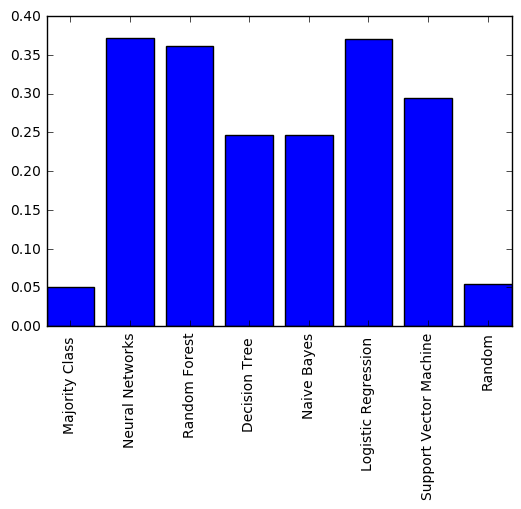

In [39]:
plt.xticks(range(len(global_accuracy_scores)), global_accuracy_scores.keys(), rotation=90)
plt.bar(range(len(global_accuracy_scores)), global_accuracy_scores.values(), align='center')

# Final Model: Logistic Regression

When looking at the accuracies and the graph above, we can see that Neural Networks, Random Forest and Logistic Regression are the 3 models that fit our data the best, with Neural Networks being first by a very small margin.
However, after considering the efficiency and the speed of the processing, we chose Logistic Regression as it is the model that is the less complicated, the fastest and the most efficient, as it is gives a slightly better accuracy than Random Forest and a slightly lower one than Neural Network, whereas the latter is a lot slower.

As a result, to better illustrate the predictions made, we can draw a confusion matrix and look at the top positive and top negative features of our data relative to our Logistic Regression model.

In [44]:
print("Logistic regression cross-validation performance: accuracy=" + str(global_accuracy_scores['Logistic Regression ']))

Logistic regression cross-validation performance: accuracy=0.371


## Splitting and fitting

In [41]:
x_train, x_test, y_train, y_test = train_test_split(sc_attributes, target_multinomial, train_size=0.67, random_state=1)

best_model =  LogisticRegression(C=lr_best_c, multi_class='multinomial', solver='newton-cg')
best_model_fitted = best_model.fit(x_train,y_train)

## Confusion Matrix

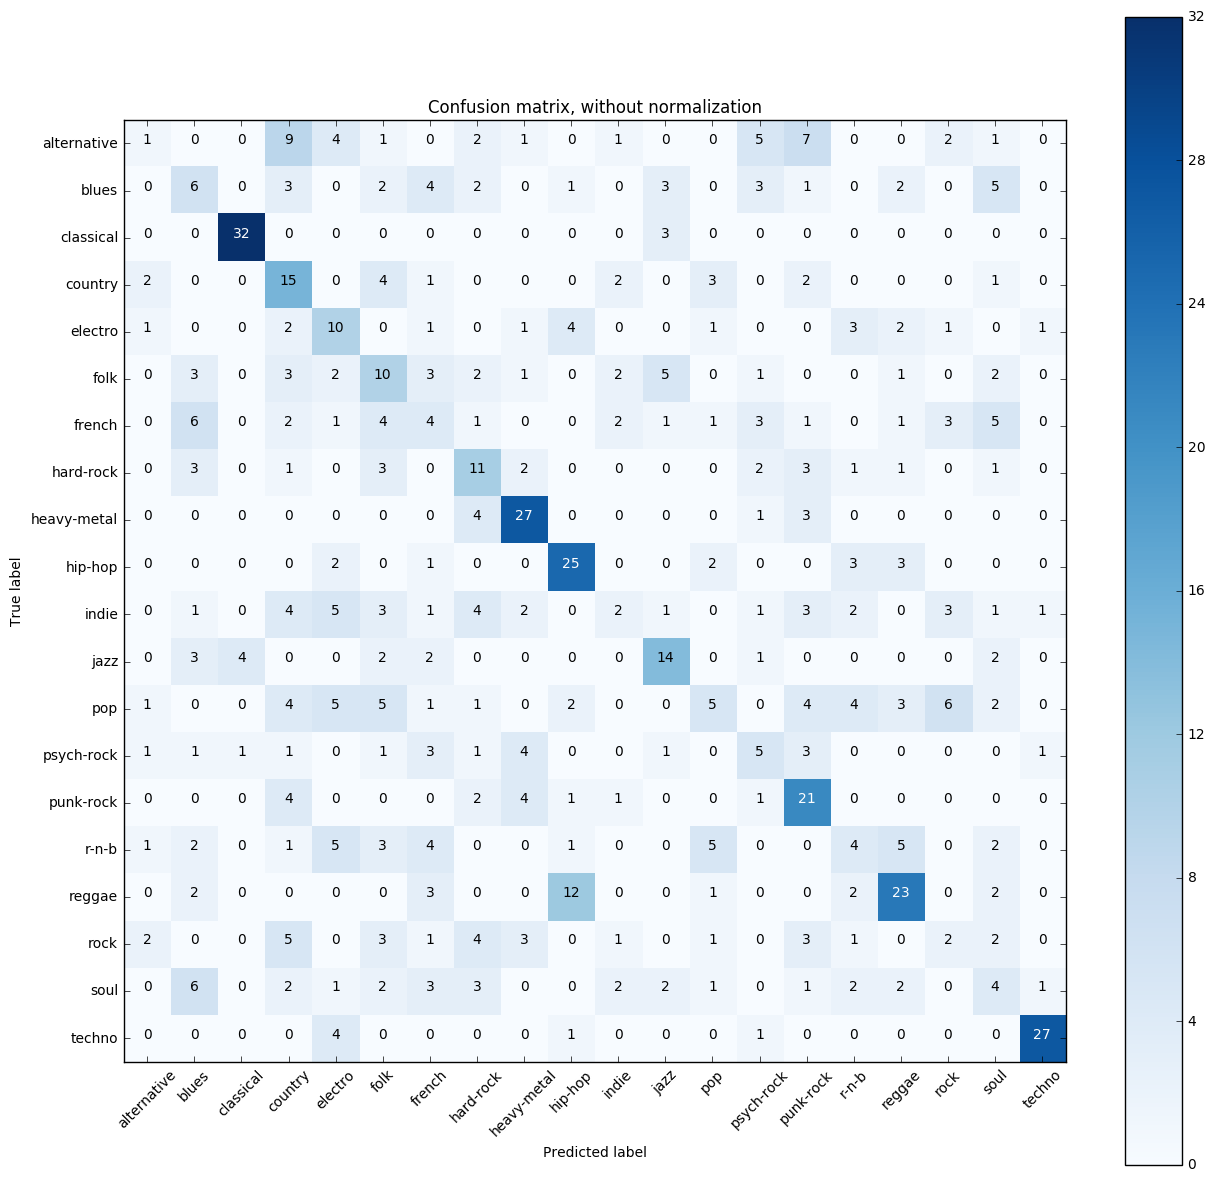

In [42]:
cnf_mat_model(best_model,sc_attributes,target_multinomial)

## Important Features

In [43]:
indices_max_weights = np.argmax(best_model_fitted.coef_, axis=1)
indices_min_weights = np.argmin(best_model_fitted.coef_, axis=1)

for index,genre in enumerate(GENRES):
    print('%s:' % genre)
    print('\tBest attribute %s - weights=%0.3f' % (pd_attributes.columns.values[indices_max_weights[index]], best_model_fitted.coef_[index][indices_max_weights[index]]))
    print('\tWorst attribute %s - weights=%0.3f' % (pd_attributes.columns.values[indices_min_weights[index]], best_model_fitted.coef_[index][indices_min_weights[index]]))

alternative:
	Best attribute loudness - weights=0.745
	Worst attribute speechiness - weights=-0.538
blues:
	Best attribute acousticness - weights=1.906
	Worst attribute energy - weights=-1.270
classical:
	Best attribute acousticness - weights=3.015
	Worst attribute danceability - weights=-3.361
country:
	Best attribute acousticness - weights=1.671
	Worst attribute instrumentalness - weights=-13.466
electro:
	Best attribute instrumentalness - weights=1.689
	Worst attribute valence - weights=-0.926
folk:
	Best attribute acousticness - weights=1.881
	Worst attribute speechiness - weights=-1.356
french:
	Best attribute acousticness - weights=2.289
	Worst attribute energy - weights=-1.127
hard-rock:
	Best attribute energy - weights=1.237
	Worst attribute loudness - weights=-1.120
heavy-metal:
	Best attribute energy - weights=4.239
	Worst attribute acousticness - weights=-21.172
hip-hop:
	Best attribute danceability - weights=2.461
	Worst attribute instrumentalness - weights=-1.760
indie:
	B